## FastSLAM1.0

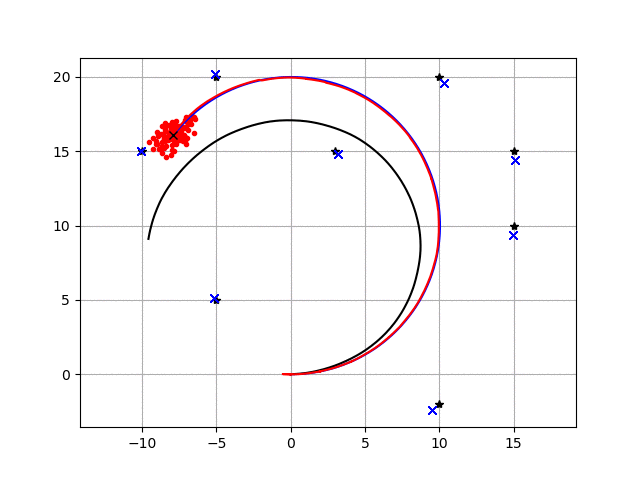

In [1]:
from IPython.display import Image
Image(filename="animation.png",width=600)

![gif](https://github.com/AtsushiSakai/PythonRobotics/raw/master/SLAM/FastSLAM1/animation.gif)

### Introduction

FastSLAM algorithm implementation is based on particle filters and belongs to the family of probabilistic SLAM approaches. It is used with feature-based maps (see gif above) or  with occupancy grid maps.

As it is shown, the particle filter differs from EKF by representing the robot's estimation through a set of particles. Each single particle has an independent belief, as it holds the pose $(x, y, \theta)$ and an array of landmark locations $[(x_1, y_1), (x_2, y_2), ... (x_n, y_n)]$ for n landmarks.

* The blue line is the true trajectory
* The red line is the estimated trajectory
* The red dots represent the distribution of particles
* The black line represent dead reckoning tracjectory
* The blue x is the observed and estimated landmarks
* The black x is the true landmark

I.e. Each particle maintains a deterministic pose and n-EKFs for each landmark and update it with each measurement.

### Algorithm walkthrough

The particles are initially drawn from a uniform distribution the represent the initial uncertainty.
At each time step we do:

* Predict the pose for each particle by using $u$ and the motion model (the landmarks are not updated). 
* Update the particles with observations $z$, where the weights are adjusted based on how likely the particle to have the correct pose given the sensor measurement
* Resampling such that the particles with the largest weights survive and the unlikely ones with the lowest weights die out.



### 1- Predict
The following equations and code snipets we can see how the particles distribution evolves in case we provide only the control $(v,w)$, which are the linear and angular velocity repsectively. 

$\begin{equation*}
F=
\begin{bmatrix}
1 & 0 & 0 \\
0 & 1 & 0 \\
0 & 0 & 1 
\end{bmatrix}
\end{equation*}$

$\begin{equation*}
B=
\begin{bmatrix}
\Delta t cos(\theta) & 0\\
\Delta t sin(\theta) & 0\\
0 & \Delta t
\end{bmatrix}
\end{equation*}$

$\begin{equation*}
X = FX + BU 
\end{equation*}$


$\begin{equation*}
\begin{bmatrix}
x_{t+1} \\
y_{t+1} \\
\theta_{t+1}
\end{bmatrix}=
\begin{bmatrix}
1 & 0 & 0 \\
0 & 1 & 0 \\
0 & 0 & 1 
\end{bmatrix}\begin{bmatrix}
x_{t} \\
y_{t} \\
\theta_{t}
\end{bmatrix}+
\begin{bmatrix}
\Delta t cos(\theta) & 0\\
\Delta t sin(\theta) & 0\\
0 & \Delta t
\end{bmatrix}
\begin{bmatrix}
v_{t} + \sigma_v\\
w_{t} + \sigma_w\\
\end{bmatrix}
\end{equation*}$



In [2]:
import numpy as np
import math
from copy import deepcopy
# Fast SLAM covariance
Q = np.diag([3.0, np.deg2rad(10.0)])**2
R = np.diag([1.0, np.deg2rad(20.0)])**2

#  Simulation parameter
Qsim = np.diag([0.3, np.deg2rad(2.0)])**2
Rsim = np.diag([0.5, np.deg2rad(10.0)])**2
OFFSET_YAWRATE_NOISE = 0.01

DT = 0.1  # time tick [s]
SIM_TIME = 50.0  # simulation time [s]
STATE_SIZE = 3  # State size [x,y,yaw]
N_PARTICLE = 100  # number of particle

class Particle:

    def __init__(self, N_LM):
        self.w = 1.0 / N_PARTICLE
        self.x = np.random.uniform(-0.1,0.1,1)[0]
        self.y = np.random.uniform(-0.1,0.1,1)[0]
        self.yaw = 0.0

def motion_model(x, u):
    F = np.array([[1.0, 0, 0],
                  [0, 1.0, 0],
                  [0, 0, 1.0]])

    B = np.array([[DT * math.cos(x[2, 0]), 0],
                  [DT * math.sin(x[2, 0]), 0],
                  [0.0, DT]])
    x = F @ x + B @ u
        
    x[2, 0] = pi_2_pi(x[2, 0])
    return x
    
def predict_particles(particles, u):
    for i in range(N_PARTICLE):
        px = np.zeros((STATE_SIZE, 1))
        px[0, 0] = particles[i].x
        px[1, 0] = particles[i].y
        px[2, 0] = particles[i].yaw
        ud = u + (np.random.randn(1, 2) @ R).T  # add noise
        px = motion_model(px, ud)
        particles[i].x = px[0, 0]
        particles[i].y = px[1, 0]
        particles[i].yaw = px[2, 0]

    return particles

def pi_2_pi(angle):
    return (angle + math.pi) % (2 * math.pi) - math.pi


N_LM = 0 
particles = [Particle(N_LM) for i in range(N_PARTICLE)]
time= 0.0
v = 1.0  # [m/s]
yawrate = 0.1  # [rad/s]
u = np.array([v, yawrate]).reshape(2, 1)
history = []
while SIM_TIME >= time:
    time += DT
    particles = predict_particles(particles, u)
    history.append(deepcopy(particles))


The following snipets playsback the recorded trajectory of each particle.

To get the insight of the motion model change the value of $R$ and re-run the cells again. As R is the parameters that indicates how much we trust that the robot executed the motion commands.

It is interesting to notice also that only motion will increase the uncertainty in the system as the particles start to spread out more. If observations are included the uncertainty will decrease and particles will converge to the correct estimate.

In [3]:
# from IPython.html.widgets import *
from ipywidgets import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# playback the recorded motion of the particles
def plot_particles(t=0):
    x = []
    y = []
    for i in range(len(history[t])):
        x.append(history[t][i].x)
        y.append(history[t][i].y)
    plt.figtext(0.15,0.82,'t = ' + str(t))
    plt.plot(x, y, '.r')
    plt.axis([-20,20, -5,25])

interact(plot_particles, t=(0,499,1));

interactive(children=(IntSlider(value=0, description='t', max=499), Output()), _dom_classes=('widget-interact'…

### 2- Update

work in progress

### References

http://www.probabilistic-robotics.org/